In [1]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=ead817a757b1e0713da6420c0c3dff87f1d584e2c630b342b5ee5f542b877154
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


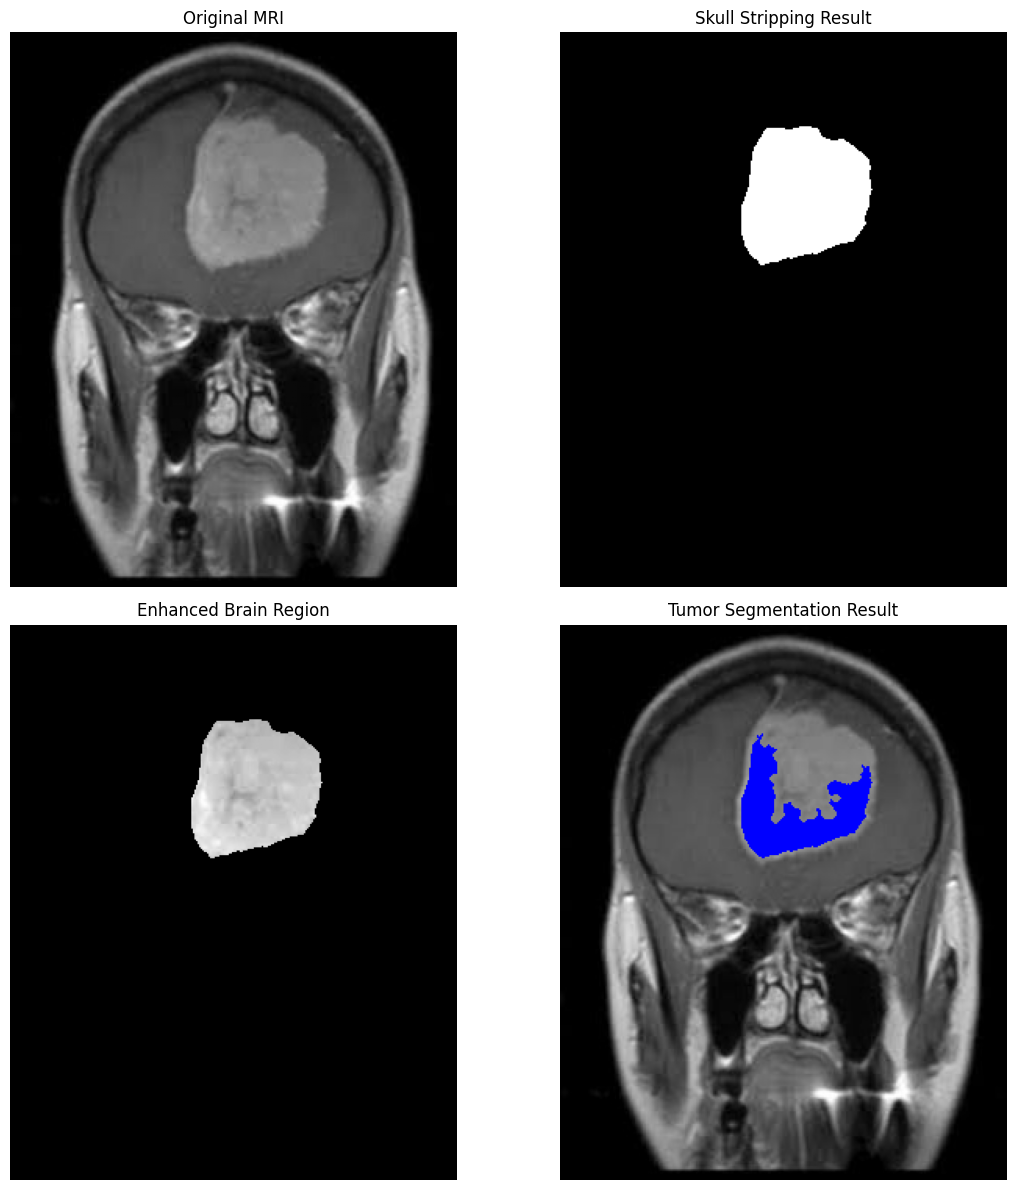

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import exposure, filters, morphology, feature, measure, segmentation
from scipy import ndimage
import random
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

class Particle:
    def __init__(self, dimensions, x_min, x_max):
        self.position = np.random.uniform(x_min, x_max, dimensions)
        self.velocity = np.zeros(dimensions)
        self.best_position = self.position.copy()
        self.best_fitness = float('-inf')
        self.fitness = float('-inf')

class PSO_WOA_Optimizer:
    def __init__(self, dimensions=3, n_particles=30, n_whales=20,
                 max_iter_pso=50, max_iter_woa=30):
        self.dimensions = dimensions
        self.n_particles = n_particles
        self.n_whales = n_whales
        self.max_iter_pso = max_iter_pso
        self.max_iter_woa = max_iter_woa

        # Parameter bounds: [intensity_threshold, size_threshold, edge_weight]
        self.x_min = np.array([0.4, 50, 0.2])
        self.x_max = np.array([0.9, 600, 0.8])

        # PSO parameters
        self.w = 0.7  # Inertia weight
        self.c1 = 1.5  # Cognitive coefficient
        self.c2 = 1.5  # Social coefficient

        # WOA parameters
        self.a_max = 2
        self.a_min = 0

        self.particles = [Particle(dimensions, self.x_min, self.x_max)
                         for _ in range(n_particles)]
        self.global_best_position = None
        self.global_best_fitness = float('-inf')

    def evaluate_fitness(self, position, image, tumor_roi, brain_mask):
        intensity_threshold, size_threshold, edge_weight = position

        # Create initial segmentation
        threshold_val = intensity_threshold * np.max(image[tumor_roi])
        segmentation = np.zeros_like(image, dtype=bool)
        segmentation[tumor_roi] = image[tumor_roi] > threshold_val

        # Post-processing
        segmentation = morphology.remove_small_objects(segmentation, int(size_threshold))
        edges = filters.sobel(image)
        edge_factor = 1 - edge_weight * (edges / (np.max(edges) + 1e-6))
        segmentation &= (edge_factor > 0.5)
        segmentation &= brain_mask

        if np.sum(segmentation) == 0:
            return float('-inf')

        # Region properties
        region = max(measure.regionprops(segmentation.astype(int)),
                    key=lambda x: x.area, default=None)

        if not region:
            return float('-inf')

        # Intensity features
        tumor_intensity = np.mean(image[segmentation])
        bg_intensity = np.mean(image[brain_mask & ~segmentation])
        intensity_ratio = tumor_intensity / (bg_intensity + 1e-6)

        # Shape features
        compactness = (4 * np.pi * region.area) / (region.perimeter**2 + 1e-6)

        # Texture features
        texture = self._calculate_texture(image, segmentation, region)

        # Bone exclusion features
        bone_threshold = np.percentile(image[brain_mask], 95)
        bone_content = np.sum(segmentation & (image > bone_threshold)) / region.area

        fitness = (3.0 * compactness +
                 2.5 * intensity_ratio +
                 1.8 * texture['homogeneity'] -
                 2.0 * texture['contrast'] -
                 4.0 * bone_content)

        return fitness

    def _calculate_texture(self, image, segmentation, region):
        # Extract tumor subimage
        minr, minc, maxr, maxc = region.bbox
        sub_image = image[minr:maxr, minc:maxc]
        sub_mask = segmentation[minr:maxr, minc:maxc]

        # Normalize and convert to uint8
        normalized = cv2.normalize(sub_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        masked = normalized * sub_mask

        if np.sum(masked) == 0:
            return {'contrast': 0, 'homogeneity': 0}

        try:
            glcm = feature.graycomatrix(
                masked,
                distances=[1],
                angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                levels=256,
                symmetric=True,
                normed=True
            )
            return {
                'contrast': np.mean(feature.graycoprops(glcm, 'contrast')),
                'homogeneity': np.mean(feature.graycoprops(glcm, 'homogeneity'))
            }
        except:
            return {'contrast': 0, 'homogeneity': 0}

    def run_pso(self, image, tumor_roi, brain_mask):
        for _ in range(self.max_iter_pso):
            for particle in self.particles:
                particle.fitness = self.evaluate_fitness(
                    particle.position, image, tumor_roi, brain_mask
                )

                if particle.fitness > particle.best_fitness:
                    particle.best_fitness = particle.fitness
                    particle.best_position = particle.position.copy()

                    if particle.best_fitness > self.global_best_fitness:
                        self.global_best_fitness = particle.best_fitness
                        self.global_best_position = particle.best_position.copy()

            for particle in self.particles:
                r1, r2 = np.random.random(2)
                cognitive = self.c1 * r1 * (particle.best_position - particle.position)
                social = self.c2 * r2 * (self.global_best_position - particle.position)
                particle.velocity = self.w * particle.velocity + cognitive + social
                particle.position = np.clip(particle.position + particle.velocity,
                                           self.x_min, self.x_max)

        return self.global_best_position

    def run_woa(self, image, tumor_roi, brain_mask, initial_solution):
        whales = np.tile(initial_solution, (self.n_whales, 1))
        whales += 0.1 * (self.x_max - self.x_min) * (np.random.random(whales.shape) - 0.5)
        whales = np.clip(whales, self.x_min, self.x_max)

        fitness = np.array([self.evaluate_fitness(w, image, tumor_roi, brain_mask)
                          for w in whales])
        leader_idx = np.argmax(fitness)
        leader_pos, leader_score = whales[leader_idx], fitness[leader_idx]

        for iter_num in range(self.max_iter_woa):
            a = self.a_max - iter_num * (self.a_max - self.a_min)/self.max_iter_woa

            for i in range(self.n_whales):
                r1, r2 = np.random.random(2)
                A = 2 * a * r1 - a
                C = 2 * r2
                p = np.random.random()
                l = np.random.uniform(-1, 1)

                if p < 0.5:
                    if abs(A) < 1:
                        D = abs(C * leader_pos - whales[i])
                        whales[i] = leader_pos - A * D
                    else:
                        rand_whale = whales[np.random.randint(self.n_whales)]
                        D = abs(C * rand_whale - whales[i])
                        whales[i] = rand_whale - A * D
                else:
                    D = abs(leader_pos - whales[i])
                    whales[i] = D * np.exp(l * 2 * np.pi) * np.cos(2 * np.pi * l) + leader_pos

                whales[i] = np.clip(whales[i], self.x_min, self.x_max)
                current_fitness = self.evaluate_fitness(whales[i], image, tumor_roi, brain_mask)

                if current_fitness > leader_score:
                    leader_score = current_fitness
                    leader_pos = whales[i].copy()

        return leader_pos

    def optimize(self, image, tumor_roi, brain_mask):
        pso_solution = self.run_pso(image, tumor_roi, brain_mask)
        final_solution = self.run_woa(image, tumor_roi, brain_mask, pso_solution)
        return final_solution

def create_brain_mask(image):
    # Multi-threshold skull stripping
    norm_img = image.astype(float)/image.max()
    thresholds = filters.threshold_multiotsu(norm_img, classes=3)
    brain_mask = norm_img > thresholds[1]

    # Morphological refinement
    brain_mask = morphology.binary_closing(brain_mask, morphology.disk(5))
    brain_mask = morphology.binary_erosion(brain_mask, morphology.disk(3))
    brain_mask = ndimage.binary_fill_holes(brain_mask)

    # Keep largest component
    labels = measure.label(brain_mask)
    brain_mask = labels == np.argmax(np.bincount(labels.flat, weights=brain_mask.flat))

    return brain_mask

def detect_tumor_roi(image, brain_mask):
    masked = image * brain_mask
    p2, p98 = np.percentile(masked[brain_mask], (2, 98))
    enhanced = exposure.rescale_intensity(masked, in_range=(p2, p98))

    # Adaptive thresholding
    thresh = filters.threshold_otsu(enhanced[brain_mask]) * 0.85
    tumor_roi = np.zeros_like(brain_mask)
    tumor_roi[brain_mask] = enhanced[brain_mask] > thresh

    # Post-processing
    tumor_roi = morphology.remove_small_objects(tumor_roi, 100)
    tumor_roi = morphology.binary_closing(tumor_roi, morphology.disk(2))
    return tumor_roi

def process_mri(image_path):
    # Load and preprocess
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error loading image")
        return None

    # Brain extraction
    brain_mask = create_brain_mask(img)
    enhanced = img * brain_mask

    # Tumor ROI detection
    tumor_roi = detect_tumor_roi(enhanced, brain_mask)

    # Optimization
    optimizer = PSO_WOA_Optimizer(n_particles=40, max_iter_woa=40)
    params = optimizer.optimize(enhanced, tumor_roi, brain_mask)

    # Apply final segmentation
    thresh_val = params[0] * np.max(enhanced[tumor_roi])
    final_mask = (enhanced > thresh_val) & tumor_roi & brain_mask
    final_mask = morphology.remove_small_objects(final_mask, int(params[1]))

    # Post-processing
    final_mask = morphology.binary_closing(final_mask, morphology.disk(2))
    final_mask = ndimage.binary_fill_holes(final_mask)

    # Visualization
    display_results(img, brain_mask, enhanced, final_mask)
    return final_mask

def display_results(original, brain_mask, enhanced, final_mask):
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    # Original image
    ax[0,0].imshow(original, cmap='gray')
    ax[0,0].set_title('Original MRI')
    ax[0,0].axis('off')

    # Brain mask
    ax[0,1].imshow(brain_mask, cmap='gray')
    ax[0,1].set_title('Skull Stripping Result')
    ax[0,1].axis('off')

    # Enhanced brain
    ax[1,0].imshow(enhanced, cmap='gray')
    ax[1,0].set_title('Enhanced Brain Region')
    ax[1,0].axis('off')

    # Final segmentation
    overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    overlay[final_mask] = [0, 0, 255]
    ax[1,1].imshow(overlay)
    ax[1,1].set_title('Tumor Segmentation Result')
    ax[1,1].axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/tumor_result.png')
    plt.show()

# Execute the pipeline
if __name__ == "__main__":
    image_path = '/content/drive/MyDrive/psoimage.jpg'
    result_mask = process_mri(image_path)
